# Statistic Canada - Data Science Fellowship Exam

Loading dependencies

In [ ]:
# System and IO libraries
import os
import scipy.io as sio

# CV libraries
import cv2
import PIL

# ML libraries
import numpy as np
import scipy
import sklearn
import torch
import torchvision
import random

Initialize seed for reproducibility

In [ ]:
random.seed(1234)

## Data collection and preprocessing

We can use bash commands to download and unzip the data for more convenience and to avoid memory issues when downloading large files using python requests library

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
!wget http://ai.stanford.edu/~jkrause/car196/cars_annos.mat
!tar -zxvf car_ims.tgz;

The label file is a matlab file. A quick google search shows that we can use scipy to load it.

In [ ]:
cars_annos = sio.loadmat("cars_annos.mat", squeeze_me = True)

As we will be focusing only on classification and will be creating custom train test splits. We will only need the relative_im_paths and class labels.

In [ ]:
cars_annotations = {'img_paths': list(cars_annos['annotations']['relative_im_path']),
                     'labels': list(cars_annos['annotations']['class'])}

## Task 1: Mask labelled dataset

In [ ]:
def label_masker(dataset_labels, proportion):
  ''' 
  Takes a list of dataset labels (int) and a proportion that needs to 
  be masked. Returns a dictionary of the orginal list, the masked list 
  and the masked indices.

  Masked labels take the value -1
  '''

  mask_value = -1
  unique_labels = set(dataset_labels)
  masked_labels = dataset_labels.copy()

  for i in unique_labels:
    indices = np.where(np.array(dataset_labels) == i)[0]
    mask_indices = random.sample(list(indices), int(len(indices)*proportion))

    if len(mask_indices) == len(indices):
      raise ValueError('Proportion too high: all classes need to have at ' 
      'least 1 instance labelled')

    for i in mask_indices:
      masked_labels[i] = mask_value

    masked_indices = list(np.where(np.array(masked_labels) == mask_value)[0])
  
  return {'original_labels':dataset_labels,
          'masked_labels': masked_labels,
          'masked_indices': masked_indices}

## Task 2: Data cleaning

In [ ]:
from PIL import Image

While it's possible to have 3-channel images that are not RGB like remote sensing images in other spectrums. I will assume that's not the case here and follow the advice in the instructions to simply remove all images that don't have exactly 3 channels.

In [ ]:
def is_not_rgb(img_path):
  '''helper function that checks if image at given path is RGB or not'''
  
  img = np.array(Image.open(img_path))
  if len(img.shape) != 3:
    return True

  if img.shape[-1] != 3:
    return True

  return False

remove_indices = []

for idx, image_path in enumerate(cars_annotations['img_paths']):
    if is_not_rgb(image_path):
      remove_indices.append(idx)
      os.remove(image_path)

cars_annotations['img_paths'] = [path for i, path
                                 in enumerate(cars_annotations['img_paths'])
                                 if i not in remove_indices]

cars_annotations['labels'] = [l for i, l
                                 in enumerate(cars_annotations['labels'])
                                 if i not in remove_indices]

## Task 3: Dataset representation

Note: In this step, iteratively loading every image and passing through the model without GPU acceleration turned out to be painfully slow (estimated to be ~1 hour using the time library). I was able to speed this up to 3 minutes by building a dataset class and using Dataloader in pytorch to perform data loading in batches as well as using GPU acceleration.

In [ ]:
from collections import defaultdict
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

Defining a custom map-style dataset class is needed by the pytorch dataloader.
We will need also need to transform the images as Resnet18 requires the input to be tensors and stacking requires all images to have the same dimension. It is also ideal to normalize images before passing through embedding.

Since we are perform embedding before train test split, I will be doing per image normalization (normalizing every image using the image's mean and standard deviation) and not dataset normalization (normalizing every image using the datasets mean and standard deviation) to avoid data leakage.

In [ ]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, annotations, normalize = True):
        """
        Args:
            Annotations(dict): dictionary containing image paths and annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_paths = annotations['img_paths']
        self.labels = annotations['labels']
        self.normalize = normalize

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_name = self.image_paths[idx]
        img = cv2.imread(img_name)
        img_mean, img_std = cv2.meanStdDev(img)

        img_mean_flat = [i[0] for i in img_mean]
        img_std_flat = [i[0] for i in img_std]
        
        transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([224,224])])
        image_tensor = transform(img)

        label = self.labels[idx]
        
        if self.normalize:
            self.norm = transforms.Normalize(mean = img_mean_flat,
                                              std = img_std_flat)
            image_tensor = self.norm(image_tensor)
            

        sample = (image_tensor, label, idx)

        return sample

In [ ]:
cars_dataset = CarsDataset(annotations = cars_annotations)

cars_dataloader = torch.utils.data.DataLoader(cars_dataset, batch_size=64,
                                              num_workers = 2)

We download a pretrained resnet18 model and detaching the last layer to use the model to generate image embeddings. I would typically use resnet50 as it is the industry standard but I understand using the smaller and lighter weight resnet18 for this exercise. Alternatively, Simclr and MOCO are also good models to use for representation learning.

It is also usually advised to finetune the model with the custom dataset since the default ImageNet weight don't usually provide good results out of the box. But again this is a luxury given the time constraint.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = torch.nn.Identity()
model.to(device)
model.eval();

In [ ]:
cars_dataset_final = defaultdict(dict)

for images, labels, index in cars_dataloader:
  with torch.no_grad():
    images = images.to(device)
    img_embedding = model(images)

  for i, idx in enumerate(list(index.numpy())):
    img_embedding = img_embedding.cpu()
    cars_dataset_final[idx] = {'embedding': img_embedding[i], 
                        'class_idx': labels[i].item(),
                        'labelled': 1} 

In [ ]:
#Saving dataset to disk
torch.save(cars_dataset_final, './cars_dataset_final.pth')

## Task 4: Mask Cars Dataset

In [ ]:
cars_dataset_final_unmasked = torch.load('./cars_dataset_final.pth')
cars_dataset_masked = cars_dataset_final_unmasked.copy()

Using the function developped in task 1, we mask 60% of the labels to limit ourselves to have only 40% of 'labelled' data for the sake of the exercise.

In [ ]:
cars_dataset_labels = [v['class_idx'] for k, v in cars_dataset_final_unmasked.items()]
cars_mask = label_masker(cars_dataset_labels, proportion = 0.6)

for i in cars_mask['masked_indices']:
  cars_dataset_masked[i]['class_idx'] = cars_mask['masked_labels'][i]
  cars_dataset_masked[i]['labelled'] = 0

## Task 5: Train/Validation split

In [ ]:
def train_test_split(dataset_inputs, dataset_labels, training_proportion):
  '''
  Takes as input dataset_inputs, dataset_labels, and training_proportion 
  Returns training_inputs, training_labels, test_inputs, test_labels
  '''

  dataset_size = len(dataset_inputs)
  indices = list(range(dataset_size))

  split = int(dataset_size * training_proportion)
  random.shuffle(indices)

  train_idx, test_idx = indices[:split], indices[split:]

  training_inputs = [dataset_inputs[i] for i in train_idx] 
  training_labels = [dataset_labels[i] for i in train_idx]
  
  test_inputs = [dataset_inputs[i] for i in test_idx] 
  test_labels = [dataset_labels[i] for i in test_idx]

  return {
     'training_inputs': training_inputs,
     'training_labels': training_labels,
     'test_inputs': test_inputs,
     'test_labels': test_labels
  }

## Task 6: Effect of labelled data on model performance

In [ ]:
from sklearn import linear_model as lm
from sklearn.metrics import accuracy_score

In [ ]:
# Isolate the 'labelled' (not masked) instances of the cars dataset
labelled_cars_dataset = [v for k,v in cars_dataset_masked.items() if v['labelled'] == 1]

cars_inputs = [i['embedding'].numpy() for i in labelled_cars_dataset]
cars_labels = [i['class_idx'] for i in labelled_cars_dataset]

Assuming that the client has at least some background knowlege in statistics. we will either show a set of box plots (client has limited background in statistics) or perform hypothesis testing (client has strong background in statistics). Either way, we'd want to demonstrate that the model performance improvement gained from adding more data is statistically significant.

To achieve this, we will rerun the experiment 10 times for 2 sets of training proportions (50% and 75%) in the train validation split and evaluate the two population of accuracies for statistical significance. Ideally, we'd want to rerun the experiment at least 30 times for statistical significance, but it is not practical to do this with the time constraints. We can't even not use GPU acceleration to shorten the time as it's not supported by sklearn!

Note: I've decided to run SGDClassifier with default parameters like loss = 'hinge' which uses SVMs. If more time was given, the better option is to use log loss and look at the top 5 classification accuracy. Since we have almost 200 balanced classes, top 5 accuracy will be a better measure as it's a more informative way to see how the model is learning. Unfortunately, SGDClassifier with log loss (logistic regression) is 3 times slower than with hinge loss (SVM) and is not practical given the time constraints.

In [ ]:
# Training and evaluating model with 50% training data
classifier50 = lm.SGDClassifier()

accuracy_50 = []

for i in range(10):
  
  #setting individual random seed for reproducibility
  random.seed(i)

  cars_train_test50 = train_test_split(cars_inputs, cars_labels, 
                                    training_proportion = 0.5)

  cars_inputs50_train = cars_train_test50['training_inputs']
  cars_labels50_train = cars_train_test50['training_labels']
  cars_inputs50_test = cars_train_test50['test_inputs']
  cars_labels50_test = cars_train_test50['test_labels']

  classifier50.fit(cars_inputs50_train, cars_labels50_train)
  y_pred50 = classifier50.predict(cars_inputs50_test)
  accuracy_50.append(accuracy_score(cars_labels50_test, y_pred50))

In [ ]:
# Training and evaluating model with 75% training data
classifier75 = lm.SGDClassifier()

accuracy_75 = []

for i in range(10):
  random.seed(i)

  cars_train_test75 = train_test_split(cars_inputs, cars_labels, 
                                    training_proportion = 0.75)

  cars_inputs75_train = cars_train_test75['training_inputs']
  cars_labels75_train = cars_train_test75['training_labels']
  cars_inputs75_test = cars_train_test75['test_inputs']
  cars_labels75_test = cars_train_test75['test_labels']

  classifier75.fit(cars_inputs75_train, cars_labels75_train)
  y_pred75 = classifier75.predict(cars_inputs75_test)
  accuracy_75.append(accuracy_score(cars_labels75_test, y_pred75))

We will now analyze the performance difference of increasing 25% training data

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind  

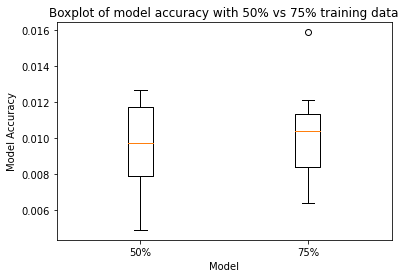

In [ ]:
fig, ax = plt.subplots()
plt.title('Boxplot of model accuracy with 50% vs 75% training data');
plt.xlabel('Model') 
plt.ylabel('Model Accuracy') 
ax.boxplot([accuracy_50,accuracy_75], labels = ['50%','75%']);

We can see from the boxplot that the mean accuracy of the model trained on 75% of the data is slightly higher than that trained on 50%. However, looking at the distributions, we can not immediately conclude that the difference is significant.

Now let's perform a t-test to see if this difference is statistically significant.

In [ ]:
ttest = ttest_ind(accuracy_75, accuracy_50, alternative = 'greater')

In [ ]:
print("The p-value is {:.2f}".format(ttest.pvalue))

The p-value is 0.27


Unfortunately, the improvement from using 75% vs 50% of training data is not statistically siginificant. This is due to the many issues previously mentioned at not having a large enough sample size (>30), using top-1 accuracy instead of top-5 accuracy. In addition, without finetuning the embedding and tuning the hyperparameters it is very diffcult for the model to learn. Notice that in both cases the accuracies obtain were hardly better than the accuracy of a random classifer (1/197 = 0.005)

## Task 7: Active learning

In [ ]:
from scipy.stats import entropy

predict_proba() requires log loss output, we will retrain a new model with log as the loss function using the entire (40%) labelled data

In [ ]:
classifier = lm.SGDClassifier(loss= 'log')
classifier.fit(cars_inputs, cars_labels)

SGDClassifier(loss='log')

we will now isolate all the unlabelled images

In [ ]:
unlabelled_cars_dataset = [(k,v['embedding']) for k,v in cars_dataset_masked.items() 
                                                          if v['labelled'] == 0]

unlabelled_cars_indices = [i[0] for i in unlabelled_cars_dataset]
unlabelled_cars_inputs = [i[1].numpy() for i in unlabelled_cars_dataset]

Now we'll calculate the entropy of the image embedding and rank them in descending order

In [ ]:
y_prob = classifier.predict_proba(unlabelled_cars_inputs)

image_entropy = [(i,entropy(p)) for i,p in zip(unlabelled_cars_indices, y_prob)]
image_entropy_rank = sorted(image_entropy, key=lambda i: i[1],
    reverse=True)

Now we take the top K images where the algorithms is most uncertain. Where K is 25% of the length of the orginal dataset (~4000)

In [ ]:
K = int(0.25*len(cars_dataset_masked.items()))

images_to_label_indices = [i[0] for i in image_entropy_rank[:K]]

On a side note, looking at the entropy values show that our model performs poorly in general. As the median entropy is high (>3), showing that the model was unsure about most its predictions.

In [118]:
print("Median entropy: {:.2f}".format(image_entropy_rank[int(len(image_entropy_rank)/2)][1]))

Median entropy: 3.71


Now we construct the final dataset

In [ ]:
final_cars_dataset_masked = cars_dataset_masked.copy()

for i in images_to_label_indices:
  final_cars_dataset_masked[i]['class_idx'] = cars_mask['original_labels'][i]
  final_cars_dataset_masked[i]['labelled'] = 1

# Isolate the 'labelled' (not masked) instances of the cars dataset
final_labelled_cars_dataset = [v for k,v in final_cars_dataset_masked.items()
                                                       if v['labelled'] == 1]

final_cars_inputs = [i['embedding'].numpy() for i in final_labelled_cars_dataset]
final_cars_labels = [i['class_idx'] for i in final_labelled_cars_dataset]

## Task 8: Final model training and evaluation

For the final model, we will split the data using a classic 70/30 split for training and test. Given the time limitation, we won't experiment with new models and do hyper-parameter tuning. I will use the same set up used in Task 6.

In [111]:
classifier_final = lm.SGDClassifier(loss = 'log')

cars_final_train_test = train_test_split(final_cars_inputs, final_cars_labels, 
                                                    training_proportion = 0.7)

cars_inputs_train_final = cars_final_train_test['training_inputs']
cars_labels_train_final = cars_final_train_test['training_labels']
cars_inputs_test_final = cars_final_train_test['test_inputs']
cars_labels_test_final = cars_final_train_test['test_labels']

classifier_final.fit(cars_inputs_train_final, cars_labels_train_final)
y_pred_final = classifier_final.predict_proba(cars_inputs_test_final)

Since we are only training one model, we can look at more metrics like top 5 accuracy to have a wholistic view of model performace

In [112]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import f1_score

In [119]:
top_1_accuracy = top_k_accuracy_score(cars_labels_test_final, y_pred_final, k = 1)
top_5_accuracy = top_k_accuracy_score(cars_labels_test_final, y_pred_final, k = 5)

print("The top 5 accuracy is {:.3f}".format(top_5_accuracy))
print("The top 1 accuracy is {:.3f}".format(top_1_accuracy))

The top 5 accuracy is 0.041
The top 1 accuracy is 0.007


The model performance is still poor (slightly higher than the random classifier accuracy of 0.005). Although the top 5 accuracy is significantly higher than that of a random classifier, showing that the model was still learning (albeit very slowly). In an a classical ML setting where better performance is the goal, I would definitely focus more on 1) finetuning the embedding model 2) Tuning hyperparameters.

Given the contraints of the exercise, we are unable to determine if labelling more data was the right decision since our model suffers from poor performance due to other issues (no finetuning, no hyperparameter tuning, etc).

In general, having more labelled data will always have a positive effect on model performance (it certainly won't make the model perform worse). However, the decision to label more instances can not be decided from just the machine-learning perspective. It depends on a number of factors such as the what the desired model performance is (not simply higher is better), the cost of labelling, etc. A detailed cost-benefit analysis will need to be done together with the client to make the decision of labelling more instances or not.